## CSE455/CSE552 – Machine Learning (Spring 2022)
### Homework #1
#### Umit ALTINTAS -- 171044005

In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.svm as svm
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score, cross_val_predict, KFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
import scipy.spatial.distance
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree._tree import Tree, TREE_UNDEFINED
import numbers

### KNN IMPLEMENTATION

In [276]:
## implementation of knn classsifer without sklearn whic takes k and metric params
class KNNClassifier:

    def __init__(self, k=5, metric='euclidean'):
        self.k = k
        self.metric = metric
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.classes = None

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.classes = np.unique(y_train)
        return self

    def predict(self, X_test):
        self.X_test = X_test
        y_pred = []
        for i in range(self.X_test.shape[0]):
            # calculate distances
            distances = scipy.spatial.distance.cdist(self.X_train,
                                                     self.X_test[i, :].reshape(
                                                         1, -1),
                                                     metric=self.metric)
            # sort the distances
            sorted_indices = np.argsort(distances, axis=0)
            # get the indices of the k nearest neighbors
            k_nearest_indices = sorted_indices[:self.k]
            # get the classes of the k nearest neighbors
            # print(k_nearest_indices.flatten())
            k_nearest_classes = [
                self.y_train.iloc[i] for i in k_nearest_indices.flatten()
            ]

            # get the most common class
            most_common_class = Counter(k_nearest_classes).most_common(1)[0][0]
            y_pred.append(most_common_class)
        return y_pred

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return np.sum(y_pred == y_test) / len(y_test)


### READ DATA AND DROP SOME UNUSEFULL COLUMNS


In [277]:
bank_data = pd.read_csv('bank.csv', sep=';')
bank_data = bank_data.dropna().drop(['month','day'],axis=1)

Y = bank_data['y']
X = bank_data.drop(['y'], axis=1)
X

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,30,unemployed,married,primary,no,1787,no,no,cellular,79,1,-1,0,unknown
1,33,services,married,secondary,no,4789,yes,yes,cellular,220,1,339,4,failure
2,35,management,single,tertiary,no,1350,yes,no,cellular,185,1,330,1,failure
3,30,management,married,tertiary,no,1476,yes,yes,unknown,199,4,-1,0,unknown
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,226,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,329,5,-1,0,unknown
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,153,1,-1,0,unknown
4518,57,technician,married,secondary,no,295,no,no,cellular,151,11,-1,0,unknown
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,129,4,211,3,other


### TRANSFORM DATA TO NUMERICAL VALUES TO CALCULATIONS
For this purpose I use make_collumn_transformer function

In [278]:
ordinalEncoder = OrdinalEncoder()
oneHotEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
labelEncoder = LabelEncoder()

column_transformer = make_column_transformer(
    (ordinalEncoder, ['education', 'poutcome']), (oneHotEncoder, [
        'job',
        'housing',
        'marital',
        'default',
        'loan',
        'contact',
    ]),
    remainder='passthrough')

X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
)


## PART-1 KNN WITH EUCLIDEAN

Accuracy: 88.386% (1.590%)
              precision    recall  f1-score   support

          no       0.91      0.97      0.94      3203
         yes       0.50      0.23      0.31       413

    accuracy                           0.89      3616
   macro avg       0.70      0.60      0.62      3616
weighted avg       0.86      0.89      0.87      3616



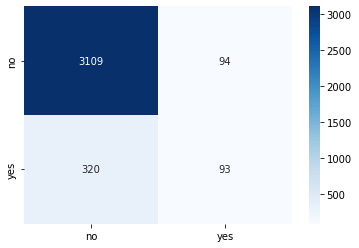

In [279]:
pipeline = Pipeline([('column_transformer', column_transformer),
                     ('scaler', StandardScaler()),
                     ('classifier', KNNClassifier(k=4, metric='euclidean'))])

pipeline.fit(X_train, y_train)
# k-fold cross validation
k_fold = KFold(n_splits=5, shuffle=True)

results = cross_val_score(pipeline, X_train, y_train, cv=k_fold)
print("Accuracy: %.3f%% (%.3f%%)" %
      (results.mean() * 100, results.std() * 100))

y_pred = cross_val_predict(pipeline, X_train, y_train, cv=k_fold)
cm=confusion_matrix(y_train, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'],
                yticklabels=['no', 'yes'])
print(classification_report(y_train, y_pred))




As we can see from confussion matrix, knn with euclidean distance function is relatively successfull for 'no' output but when we look the 'yes' it did not perform same performance for 'yes'

## PART-2 KNN WITH MANHATTAN



Accuracy: 88.302% (1.527%)
              precision    recall  f1-score   support

          no       0.90      0.97      0.94      3203
         yes       0.44      0.17      0.25       413

    accuracy                           0.88      3616
   macro avg       0.67      0.57      0.59      3616
weighted avg       0.85      0.88      0.86      3616



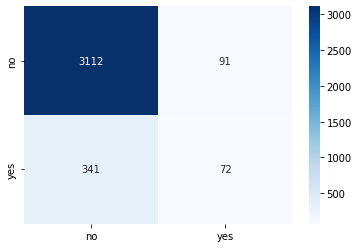

In [280]:
pipeline = Pipeline([('column_transformer', column_transformer),
                     ('scaler', StandardScaler()),
                     ('classifier', KNNClassifier(k=4, metric='cityblock'))])

pipeline.fit(X_train, y_train)
# k-fold cross validation
k_fold = KFold(n_splits=5, shuffle=True)

results = cross_val_score(pipeline, X_train, y_train, cv=k_fold)
print("Accuracy: %.3f%% (%.3f%%)" %
      (results.mean() * 100, results.std() * 100))

y_pred = cross_val_predict(pipeline, X_train, y_train, cv=k_fold)
cm = confusion_matrix(y_train, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'],
                yticklabels=['no', 'yes'])
print(classification_report(y_train, y_pred))


Result shows us the knn with manhattan distance funtion's performance is almost same with the knn with the euclidean function.


## PART-3 SVM LINEAR

Accuracy: 88.523% (1.071%)
              precision    recall  f1-score   support

          no       0.88      1.00      0.94      4000
         yes       0.00      0.00      0.00       521

    accuracy                           0.88      4521
   macro avg       0.44      0.50      0.47      4521
weighted avg       0.78      0.88      0.83      4521



/home/umit/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/umit/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/umit/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/umit/.local/lib/python3.10/site-packa

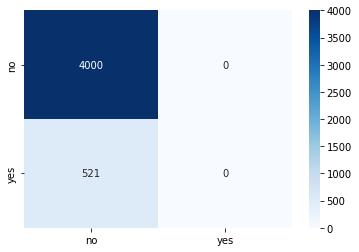

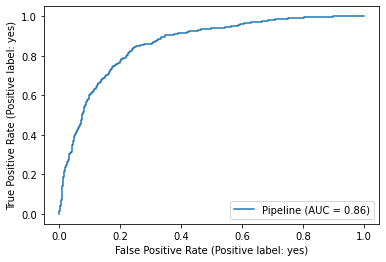

In [281]:
## You may use an available implementation of SVM in Python.
# o Report performance using an appropriate k-fold cross validation using ROC curves and
# confusion matrices. Find the best threshold for the SVM output as described in the
# note by Fawcett.
# o Report the run time performance of your above tests.

pipeline = Pipeline([('column_transformer', column_transformer),
                     ('scaler', StandardScaler()),
                     ('classifier', svm.SVC(kernel='linear', C=1))])

pipeline.fit(X_train, y_train)
# k-fold cross validation
k_fold = KFold(n_splits=5, shuffle=True)

results = cross_val_score(pipeline, X_train, y_train, cv=k_fold)
print("Accuracy: %.3f%% (%.3f%%)" %
      (results.mean() * 100, results.std() * 100))

y_pred = cross_val_predict(pipeline, X, Y, cv=k_fold)
cm = confusion_matrix(Y, y_pred)
f = sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['no', 'yes'],
                yticklabels=['no', 'yes'])
print(classification_report(Y, y_pred))

## plot roc curve and auc for values yes and no
plot_roc_curve(pipeline,X_train, y_train)


The result shows us the the SVM with linear kernel is not succcesfull for detection 'yes' outputs. It always gives the 'no' output and this is not expected result.

## PART-4 SVM polynomial

Accuracy: 88.634% (0.487%)
              precision    recall  f1-score   support

          no       0.90      0.98      0.94      4000
         yes       0.55      0.15      0.23       521

    accuracy                           0.89      4521
   macro avg       0.72      0.57      0.59      4521
weighted avg       0.86      0.89      0.86      4521



/home/umit/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


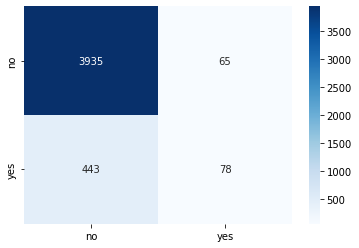

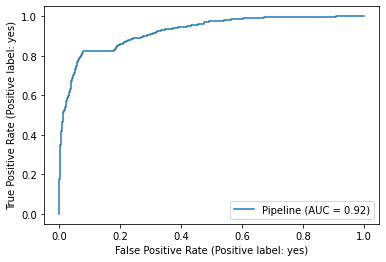

In [282]:
pipeline = Pipeline([('column_transformer', column_transformer),
                     ('scaler', StandardScaler()),
                     ('classifier', svm.SVC(kernel='poly', C=1))])

pipeline.fit(X_train, y_train)
# k-fold cross validation
k_fold = KFold(n_splits=5, shuffle=True)

results = cross_val_score(pipeline, X_train, y_train, cv=k_fold)
print("Accuracy: %.3f%% (%.3f%%)" %
      (results.mean() * 100, results.std() * 100))

y_pred = cross_val_predict(pipeline, X, Y, cv=k_fold)
cm = confusion_matrix(Y, y_pred)
f = sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['no', 'yes'],
                yticklabels=['no', 'yes'])
print(classification_report(Y, y_pred))

plot_roc_curve(pipeline,X_train, y_train)


The SVM with polynomial kernel is much more successfull for this dataset when detecting 'yes' outputs. 

## PART-5 DECISION TREE


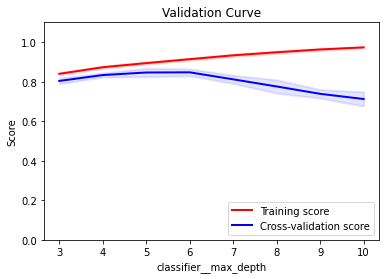

Best parameters:  {'classifier__max_depth': 6}
Best cross-validation score: 0.848


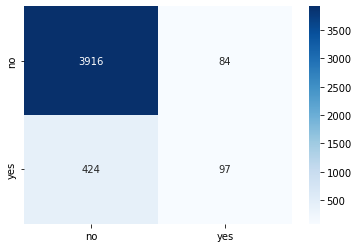

In [296]:
## a plotter for params of the classifier
def plot_grid_search_validation_curve(grid,
                                      param_to_vary,
                                      title='Validation Curve',
                                      ylim=None,
                                      xlim=None,
                                      log=None):
    """Plots train and cross-validation scores from a GridSearchCV instance's
    best params while varying one of those params."""

    df_cv_results = pd.DataFrame(grid.cv_results_)
    train_scores_mean = df_cv_results['mean_train_score']
    valid_scores_mean = df_cv_results['mean_test_score']
    train_scores_std = df_cv_results['std_train_score']
    valid_scores_std = df_cv_results['std_test_score']

    param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
    param_ranges = [grid.param_grid[p[6:]] for p in param_cols]
    param_ranges_lengths = [len(pr) for pr in param_ranges]

    train_scores_mean = np.array(train_scores_mean).reshape(
        *param_ranges_lengths)
    valid_scores_mean = np.array(valid_scores_mean).reshape(
        *param_ranges_lengths)
    train_scores_std = np.array(train_scores_std).reshape(
        *param_ranges_lengths)
    valid_scores_std = np.array(valid_scores_std).reshape(
        *param_ranges_lengths)

    param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

    slices = []
    for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().index(
                best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)

    train_scores_mean = train_scores_mean[tuple(slices)]
    valid_scores_mean = valid_scores_mean[tuple(slices)]
    train_scores_std = train_scores_std[tuple(slices)]
    valid_scores_std = valid_scores_std[tuple(slices)]

    plt.clf()

    plt.title(title)
    plt.xlabel(param_to_vary)
    plt.ylabel('Score')

    if (ylim is None):
        plt.ylim(0.0, 1.1)
    else:
        plt.ylim(*ylim)

    if (not (xlim is None)):
        plt.xlim(*xlim)

    lw = 2

    plot_fn = plt.plot
    if log:
        plot_fn = plt.semilogx

    param_range = param_ranges[param_to_vary_idx]
    if (not isinstance(param_range[0], numbers.Number)):
        param_range = [str(x) for x in param_range]
    plot_fn(param_range,
            train_scores_mean,
            label='Training score',
            color='r',
            lw=lw)
    plt.fill_between(np.array(param_range),
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color='r',
                     lw=lw)
    plot_fn(param_range,
            valid_scores_mean,
            label='Cross-validation score',
            color='b',
            lw=lw)
    plt.fill_between(param_range,
                     valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std,
                     alpha=0.1,
                     color='b',
                     lw=lw)

    plt.legend(loc='lower right')

    plt.show()


pipeline = Pipeline([('column_transformer', column_transformer),
                     ('scaler', StandardScaler()),
                     ('classifier',
                      DecisionTreeClassifier(criterion='entropy',
                                             max_depth=3))])

# k-fold cross validation
k_fold = KFold(n_splits=5, shuffle=True)

grid_param = {'classifier__max_depth': [3, 4, 5, 6, 7,8,9,10]}

grid_clf = GridSearchCV(pipeline,
                        param_grid=grid_param,
                        cv=k_fold,
                        scoring='roc_auc',
                        return_train_score=True)

grid_clf.fit(X_train, y_train)

plot_grid_search_validation_curve(
    grid_clf,
    'classifier__max_depth',
    log=False,
)

print("Best parameters: ", grid_clf.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_clf.best_score_))




y_pred = cross_val_predict(pipeline, X, Y, cv=k_fold)
cm = confusion_matrix(Y, y_pred)
f = sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['no', 'yes'],
                yticklabels=['no', 'yes'])

/home/umit/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/umit/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/umit/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/umit/.local/lib/python3.10/site-packages/sklearn/utils/metaestimators.py", line 109, in __get__
    if not self.check(obj):
  File "/home/umit/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 45, in check
    getattr(self._final_estimator, attr)
AttributeError: 'KNN_KD_TREE' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (mo

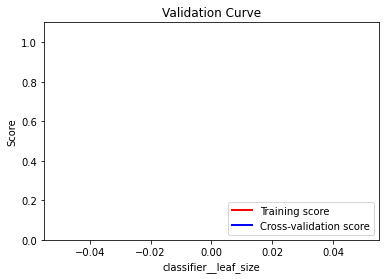

Best parameters:  {'classifier__leaf_size': 30, 'classifier__metric': 'euclidean'}
Best cross-validation score: nan


/home/umit/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/umit/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/home/umit/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/umit/.local/lib/python3.10/site-packages/sklearn/utils/metaestimators.py", line 109, in __get__
    if not self.check(obj):
  File "/home/umit/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 45, in check
    getattr(self._final_estimator, attr)
AttributeError: 'KNN_KD_TREE' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (mo

ValueError: Cannot index with multidimensional key

In [300]:
### kNN USING KD-TREE ALGORITHM
from sklearn.neighbors import KDTree


class KNN_KD_TREE:

    def __init__(
        self,
        k,
        algorithm='auto',
        leaf_size=30,
        metric='minkowski',
    ):
        self.k = k
        self.algorithm = algorithm
        self.leaf_size = leaf_size
        self.metric = metric

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, Y):
        self.kd_tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        self.Y = Y

    def predict(self, X):
        y_pred = np.zeros(len(X))
        for i, x in enumerate(X):
            dist, ind = self.kd_tree.query(x.reshape(1, -1), k=self.k)
            y_pred[i] = self.Y[ind].mode()
        return y_pred

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return np.sum(y_pred == y_test) / len(y_test)


pipe = Pipeline([('column_transformer', column_transformer),
                 ('scaler', StandardScaler()),
                 ('classifier', KNN_KD_TREE(k=5))])

k_fold = KFold(n_splits=5, shuffle=True)

grid_param = {
    'classifier__leaf_size': [30, 50, 100, 150, 200],
    'classifier__metric': ['euclidean', 'cityblock']
}

grid_clf = GridSearchCV(pipe,
                        param_grid=grid_param,
                        cv=k_fold,
                        scoring='roc_auc',
                        return_train_score=True)

grid_clf.fit(X_train, y_train)

plot_grid_search_validation_curve(
    grid_clf,
    'classifier__leaf_size',
    log=False,
)

print("Best parameters: ", grid_clf.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_clf.best_score_))

y_pred = cross_val_predict(grid_clf, X, Y, cv=k_fold)
cm = confusion_matrix(Y, y_pred)
f = sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['no', 'yes'],
                yticklabels=['no', 'yes'])
